# Clustering analysis

Use various clustering techniques to identify a good subset of questions.

---

In [2]:
%run load_data_2012.ipynb

Populating the interactive namespace from numpy and matplotlib
Variables now available: df


## Correlations in data

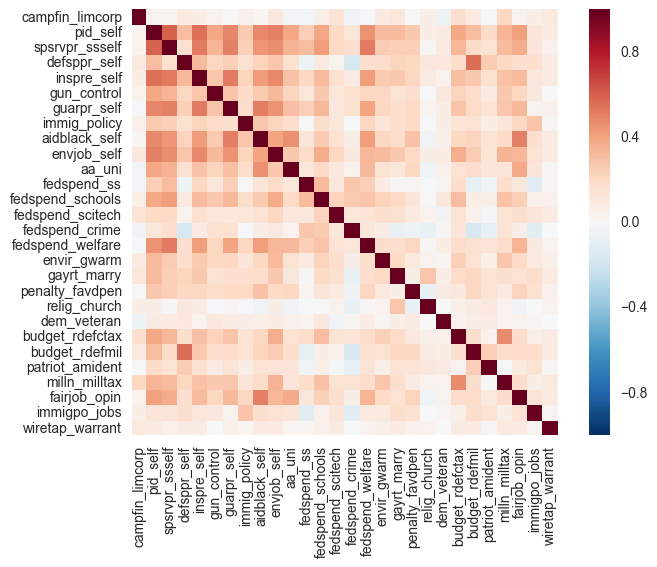

In [3]:
import seaborn as sns

# Spearman is recommended for ordinal data.
correlations = df.corr(method='spearman')
sns.heatmap(correlations,
           xticklabels=df.columns,
           yticklabels=df.columns,
           square=True);

Note that if we were to scale the data, the correlation matrix would be unchanged.

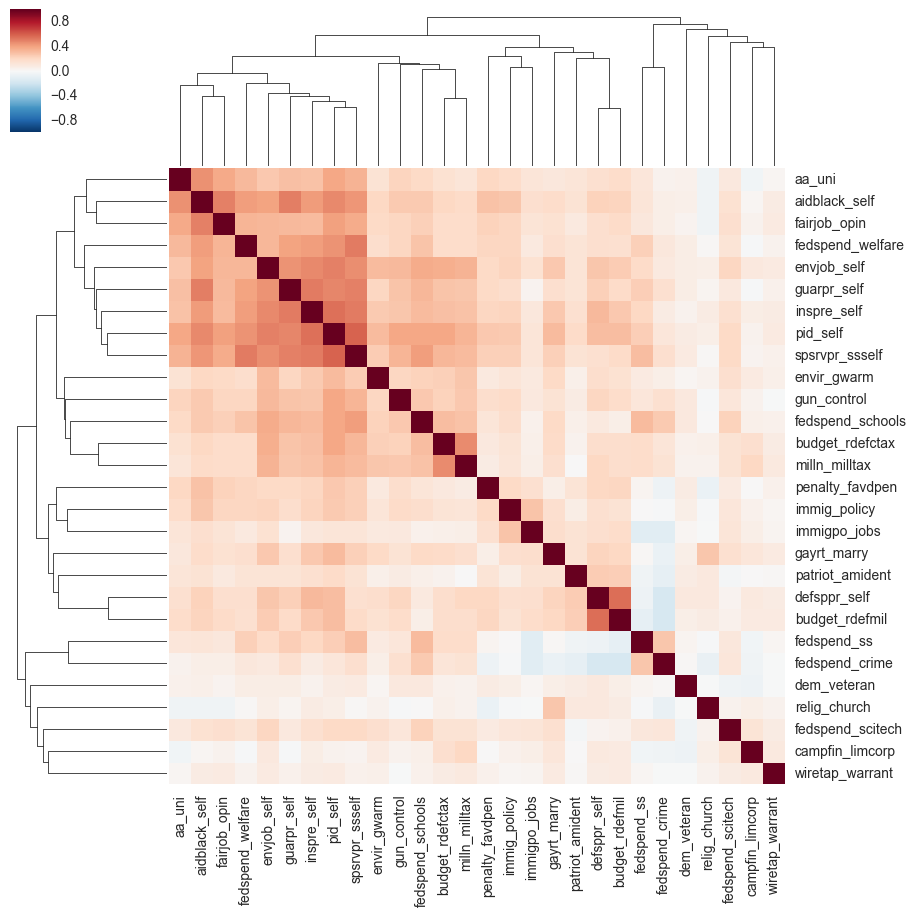

In [8]:
cg = sns.clustermap(correlations, square=True)
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(),
        rotation=0);  # Fix rotation of y-labels.

## Principal component analysis

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer, StandardScaler

imp = Imputer(strategy='mean')
scl = StandardScaler()
pca = PCA()
pipeline = Pipeline([
        ('imp', imp),
        ('scl', scl),
        ('pca', pca),
    ])
scaler_pipeline = Pipeline([
        ('imp', imp),
        ('scl', scl),
    ])
data_pca = pipeline.fit_transform(df)
_scaled = scaler_pipeline.transform(df)

### Explained variance

How much of the variance in the data is explained by each successive component?

In [9]:
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })

plot_explained_variance(pca)

### Biplot

A scatterplot projected onto the first two principal components.

In [23]:
def biplot(pca, dat, title='', show_points=True):
    
    import plotly
    from plotly.graph_objs import Scatter, Marker, Layout, XAxis, YAxis, Bar, Line
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    # 0,1 denote PC1 and PC2; change values for other PCs
    xvector = pca.components_[0] 
    yvector = pca.components_[1]

    tmp = pca.transform(dat.values)
    xs = tmp[:,0] 
    ys = tmp[:,1]
    if show_points:
        annotations = [Scatter(x=xs, y=ys, mode ='markers', name='cumulative explained variance')]
    else:
        annotations = []
    for i in range(len(xvector)):
        txt = list(dat.columns.values)[i]
        annotations.append(
                Scatter(
                    x=[0, xvector[i]*max(xs)],
                    y=[0, yvector[i]*max(ys)],
                    mode='lines+text',
                    text=['', txt],
                    name=txt,
                ))
    
    plotly.offline.iplot({
        "data": annotations,
        "layout": Layout(xaxis=XAxis(title='Principal Component One'), 
                         yaxis=YAxis(title='Principal Component Two'),
                        title=title)
    })


    plt.show()
biplot(pca, pd.DataFrame(_scaled, columns=df.columns), title='ANES 2012 Biplot', show_points=False)

Sure, all of the original axes are negative in the first component. That's okay! To quote Dr. Eric Larson: 
> Because all the data is somewhat correlated, giving a mostly unidimensional representation. Positive/negative isn't so important because eigenvectors could theoretically start anywhere--but traditionally we use the origin.

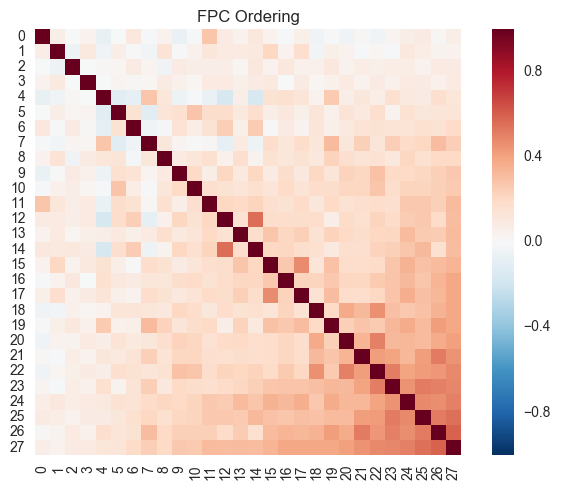

In [54]:
def fpc_ordered(corr):
    """Reorder correlation matrix based on first principal component (FPC)."""
    ew, ev = np.linalg.eig(corr)
    idx = np.argsort(ew)[::-1]  # Reordering index of eigenvalues
    ew, ev = ew[idx], ev[:, idx]
    e1 = ev[:, 0]
    order = np.argsort(e1)
    try:
        return corr.values[:, order][order]
    except AttributeError:
        return corr[:, order][order]
sns.heatmap(fpc_ordered(correlations),
           square=True)
plt.title("FPC Ordering");

### Norris ordering

Arrange correlation matrix by sum of principal components (left singular vectors), weighted by singular values.

In [10]:
U, S, V = PCA()._fit(X=_scaled)
np.allclose(U @ np.diag(S) @ V, _scaled)

True

We see something important here: normally, the singular value decomposition is $\mathbf{A} = \mathbf{U\Sigma V^T}$ where the columns of $\mathbf{V}$ are the left singular vectors. Here, we see that $\mathbf{A} = \mathbf{U\Sigma V}$. Consequently, the rows of $\mathbf{V}$ are the left singular vectors.

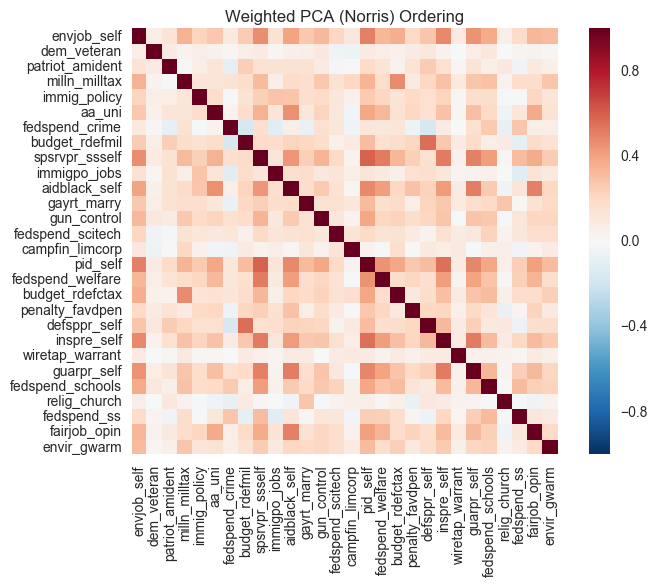

In [11]:
weights = np.abs(S @ V)  # Total weights of each scaled component
norris_ordering = np.argsort(weights)[::-1]
sns.heatmap(correlations.values[:, norris_ordering][norris_ordering],
           xticklabels=df.columns[norris_ordering],
           yticklabels=df.columns[norris_ordering],
           square=True)
plt.title("Weighted PCA (Norris) Ordering");

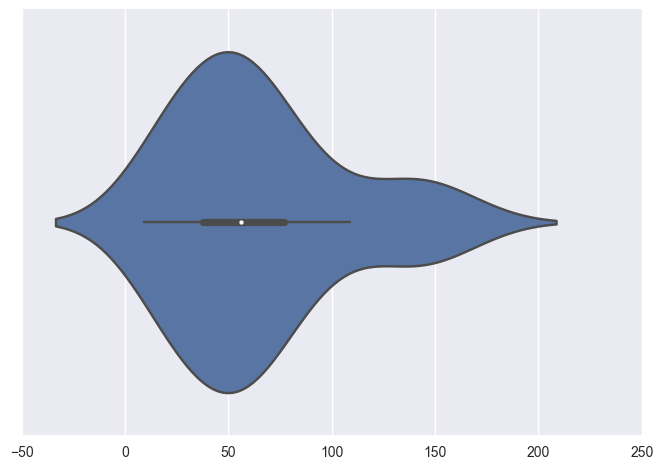

In [18]:
sns.violinplot(weights)